El código implementa y compara dos métodos numéricos de integración para Ecuaciones Diferenciales Ordinarias (EDO): Euler Explícito (orden 1) y Euler Mejorado (orden 2).

Para su análisis, el script resuelve dos problemas de la Ley de Torricelli: la Clepsydra (el problema asignado, cuya solución es lineal) y un Tanque Cilíndrico, el cual funciona como Benchmark o referencia. El código simula primero la Clepsydra para validar su diseño teórico. Luego, ejecuta los métodos con el Tanque Cilíndrico y su solución analítica para cuantificar el error, generar una tabla y una gráfica log-log, lo que permite determinar el orden de convergencia de cada algoritmo. Finalmente, realiza un Análisis de Sensibilidad (o error hacia adelante) al perturbar la condición inicial de la Clepsydra y graficar la diferencia de las trayectorias, evaluando así la estabilidad del problema ante errores de medición.

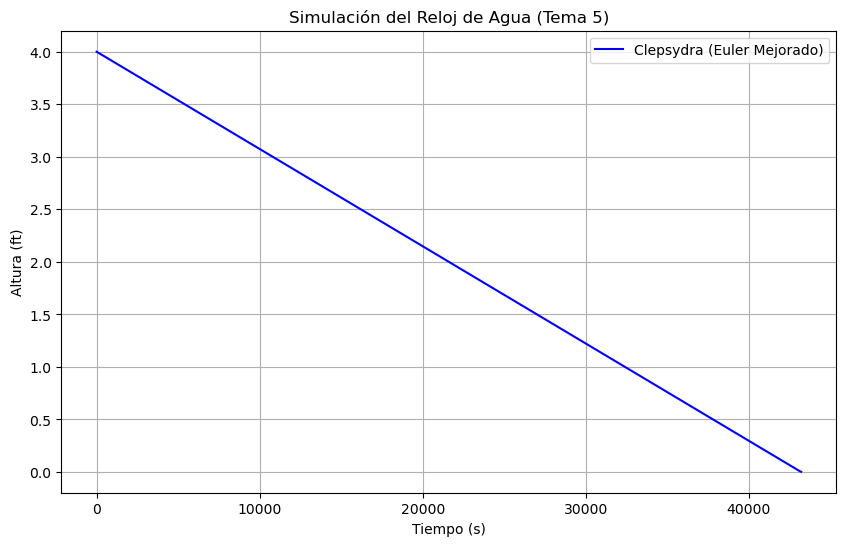


--- TABLA DE ERRORES (Usando Benchmark Cilíndrico) ---
dt         | Error Euler     | Error Mejorado 
200        | 0.000027        | 0.000000
100        | 0.000014        | 0.000000
50         | 0.000007        | 0.000000
10         | 0.000001        | 0.000000
1          | 0.000000        | 0.000000


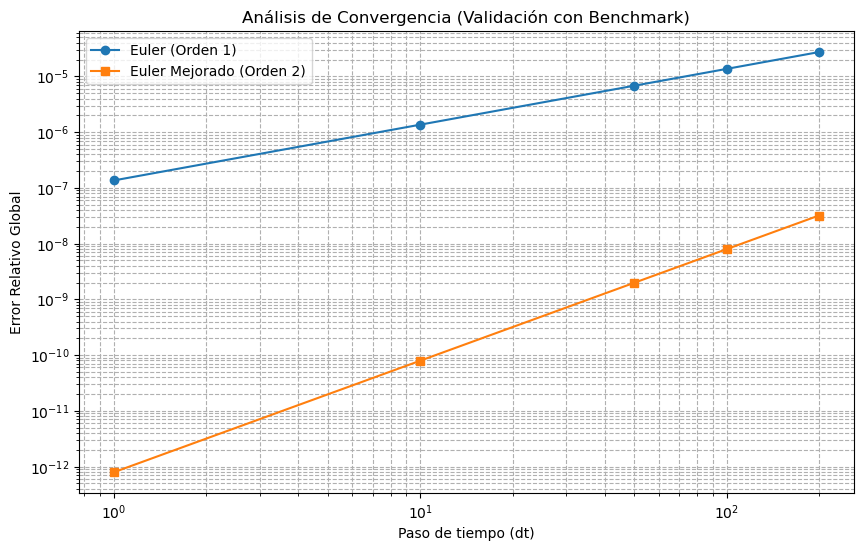

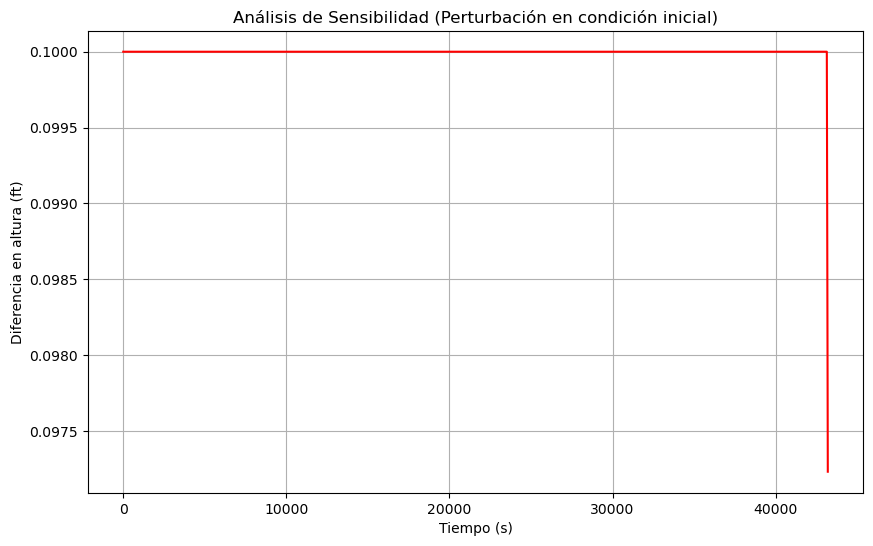

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

g = 32.0
y0 = 4.0
t_final = 12 * 3600.0  
C_ft_per_s = (4.0/12.0) / 3600.0  
r_propuesto = math.sqrt(3) / 720.0
a = math.pi * r_propuesto**2


def euler_explicit(f, t0, y0, dt, t_end):
    n_steps = int(np.floor((t_end - t0) / dt))
    ts = np.empty(n_steps+1); ys = np.empty(n_steps+1)
    ts[0] = t0; ys[0] = y0
    t = t0; y = y0
    for i in range(n_steps):
        y = y + dt * f(t, y)
        t = t + dt
        ts[i+1] = t; ys[i+1] = y
    return ts, ys

def euler_mejorado(f, t0, y0, dt, t_end):
    n_steps = int(np.floor((t_end - t0) / dt))
    ts = np.empty(n_steps+1); ys = np.empty(n_steps+1)
    ts[0] = t0; ys[0] = y0
    t = t0; y = y0
    for i in range(n_steps):
        f1 = f(t, y)
        y_predict = y + dt * f1          
        f2 = f(t + dt, y_predict)       
        y = y + dt * (f1 + f2)/2.0       
        t = t + dt
        ts[i+1] = t; ys[i+1] = y
    return ts, ys

def A_clepsydra(y):
    return math.pi * math.sqrt(max(y, 1e-9)) / 2.0

def f_clepsydra(t, y):
    if y <= 0: return 0.0
    return - a * math.sqrt(2.0 * g * y) / A_clepsydra(y)

 
R_cilindro = 1.0 
def f_cilindro(t, y):
    if y <= 0: return 0.0
    A_cte = math.pi * (R_cilindro**2)
    return - a * math.sqrt(2.0 * g * y) / A_cte


def exacta_cilindro(t, y0):
    A_cte = math.pi * (R_cilindro**2)
    k = (a * math.sqrt(2.0 * g)) / (2 * A_cte)
    term = math.sqrt(y0) - k * t
    if term < 0: return 0.0
    return term**2



dt = 60.0 
ts_clep, ys_clep = euler_mejorado(f_clepsydra, 0.0, y0, dt, t_final)

plt.figure(figsize=(10, 6))
plt.plot(ts_clep, ys_clep, label="Clepsydra (Euler Mejorado)", color='blue')
plt.title("Simulación del Reloj de Agua (Tema 5)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Altura (ft)")
plt.grid(True)
plt.legend()
plt.show() 


dt_lista = [200, 100, 50, 10, 1] 
errores_euler = []
errores_mejorado = []
tiempo_objetivo = 1000.0 

print("\n--- TABLA DE ERRORES (Usando Benchmark Cilíndrico) ---")
print(f"{'dt':<10} | {'Error Euler':<15} | {'Error Mejorado':<15}")

for paso in dt_lista:
    # 1. Euler Simple
    ts, ys = euler_explicit(f_cilindro, 0.0, y0, paso, tiempo_objetivo)
    y_num = ys[-1]
    y_real = exacta_cilindro(tiempo_objetivo, y0)
    err_e = abs(y_num - y_real) / abs(y_real) # Error relativo
    errores_euler.append(err_e)
    
    # 2. Euler Mejorado
    ts, ys = euler_mejorado(f_cilindro, 0.0, y0, paso, tiempo_objetivo)
    y_num = ys[-1]
    err_m = abs(y_num - y_real) / abs(y_real)
    errores_mejorado.append(err_m)
    
    print(f"{paso:<10} | {err_e:.6f}        | {err_m:.6f}")

# Gráfica de Convergencia (Log-Log)
plt.figure(figsize=(10, 6))
plt.loglog(dt_lista, errores_euler, 'o-', label='Euler (Orden 1)')
plt.loglog(dt_lista, errores_mejorado, 's-', label='Euler Mejorado (Orden 2)')
plt.xlabel('Paso de tiempo (dt)')
plt.ylabel('Error Relativo Global')
plt.title('Análisis de Convergencia (Validación con Benchmark)')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()


y0_perturbado = y0 + 0.1 

ts_orig, ys_orig = euler_mejorado(f_clepsydra, 0.0, y0, 60.0, t_final)
ts_pert, ys_pert = euler_mejorado(f_clepsydra, 0.0, y0_perturbado, 60.0, t_final)

diferencia = np.abs(ys_orig - ys_pert)

plt.figure(figsize=(10, 6))
plt.plot(ts_orig, diferencia, color='red')
plt.title("Análisis de Sensibilidad (Perturbación en condición inicial)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Diferencia en altura (ft)")
plt.grid(True)
plt.show()